In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
df_feat = pd.read_csv('../encoded data/opamps-features.csv')
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

# Prétraitement

In [3]:
categorical_columns = ["Supplier_Package"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Normalisation des données numériques

In [4]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

In [5]:
df["Supplier_Package"].value_counts()

Supplier_Package
SO N          234737
SOT-23        169952
TSSOP         164334
SOIC          101715
MSOP           84724
               ...  
CFP                1
EQFN-E2 EP         1
DFN-W1 EP          1
LCC                1
SSOP-A3            1
Name: count, Length: 147, dtype: int64

In [12]:
df["Cross Reference Type"].value_counts()

Cross Reference Type
D    808455
C    159451
B     36926
A     18360
Name: count, dtype: int64

In [6]:
df.head()

,Cross Reference Type,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product,MPN_comp,MANUFACTURER_comp,Maximum Input Offset Voltage_comp,Maximum Single Supply Voltage_comp,Minimum Single Supply Voltage_comp,Number of Channels per Chip_comp,Supplier_Package_comp,Typical Gain Bandwidth Product_comp
0,A,PN-1017594,MN-1030,0.0005,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017599,MN-1036,0.001,0.478261,0.153094,0.0,SOT-23,0.0001
1,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017598,MN-1036,0.001,0.478261,0.153094,0.0,SOT-23,0.0001
2,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017597,MN-1036,0.001,0.478261,0.153094,0.0,SOT-23,0.0001
3,A,PN-1017594,MN-1030,0.0005,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017598,MN-1036,0.001,0.478261,0.153094,0.0,SOT-23,0.0001
4,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017599,MN-1036,0.001,0.478261,0.153094,0.0,SOT-23,0.0001


In [9]:
df.shape[1]

17

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023192 entries, 0 to 18351
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Cross Reference Type                 1023192 non-null  object 
 1   MPN                                  1023192 non-null  object 
 2   MANUFACTURER                         1023192 non-null  object 
 3   Maximum Input Offset Voltage         1023192 non-null  float64
 4   Maximum Single Supply Voltage        1023192 non-null  float64
 5   Minimum Single Supply Voltage        1023192 non-null  float64
 6   Number of Channels per Chip          1023192 non-null  float64
 7   Supplier_Package                     1023192 non-null  object 
 8   Typical Gain Bandwidth Product       1023192 non-null  float64
 9   MPN_comp                             1023192 non-null  object 
 10  MANUFACTURER_comp                    1023192 non-null  object 
 11  Maxim

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Conversion de la Cross Reference Type en numerique

In [13]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.65, 'D': 0.5}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

In [14]:
base_scores = { #neji
    'A': 0.95,  # High score for class A (most similar)
    'B': 0.75,
    'C': 0.55,
    'D': 0.35   # Low score for class D (least similar)
}
spread=0.2

In [15]:
for col in categorical_columns:
  df["distance_"+col] = df[col] == df[col+"_comp"]
  df["distance_"+col] =1- df["distance_"+col].astype(int)

In [16]:
for col in numerical_columns:
  df["distance_"+col] = np.abs(df[col] - df[col+"_comp"])

In [17]:
df["distance"] = df[["distance_"+col for col in categorical_columns+numerical_columns]].sum(axis=1)
df["distance"] = df["distance"]/max(df["distance"])
print(f"distance entre {max(df['distance'])} and {min(df['distance'])}")

distance entre 1.0 and 0.0


In [18]:
df["Closeness"] = df["Cross Reference Type"].map(base_scores)

In [19]:
df["Closeness"] -= (df["distance"]*spread)

In [20]:
np.random.seed(42)

In [21]:
epsilon_A = np.random.normal(0, 0.005, size=len(df[(df["Cross Reference Type"] == "A") & (df["distance"] ==0 )]),)


In [22]:
df.loc[(df["Cross Reference Type"] == "A") & (df["distance"] == 0), "Closeness"] += epsilon_A

In [23]:
df.loc[df["Cross Reference Type"]!="A", "Closeness"] = df.loc[df["Cross Reference Type"]!="A", "Closeness"].apply(lambda x: np.random.normal(x, 0.001))
# Ensure Closeness remains within [0,1]
df["Closeness"] = df["Closeness"].clip(0, 1)

In [24]:
import importlib
import helper_functions.preprocess as pp

importlib.reload(pp)

<module 'helper_functions.preprocess' from 'e:\\Période1\\PIE\\PIE2024STMicro\\notebook\\helper_functions\\preprocess.py'>

<Axes: xlabel='Closeness', ylabel='Density'>

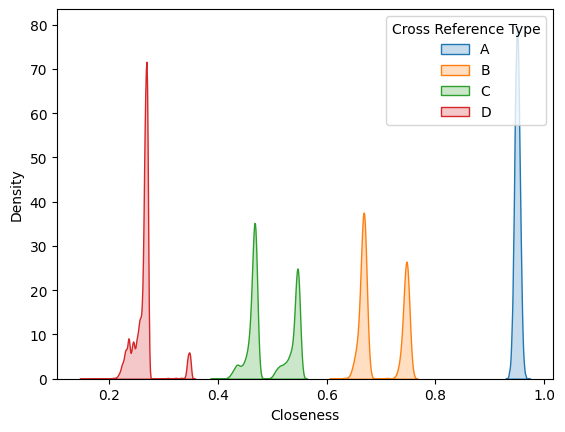

In [25]:
# df = pp.generate_closeness(df,base_means,base_std,n_std=3)
sns.kdeplot(data=df, x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

In [40]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# 参数设定
input_dim = 17
num_categories = 147
embedding_dim = 10
batch_size = 1024
num_epochs = 5
learning_rate = 1e-3

# LabelEncoding
le = LabelEncoder()
df['Supplier_Package_idx'] = le.fit_transform(df['Supplier_Package'])
df['Supplier_Package_comp_idx'] = le.transform(df['Supplier_Package_comp'])

# 构建输入数据
X = df[['Supplier_Package_idx', 'Supplier_Package_comp_idx']].values
y = df['Closeness'].values

X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 模型定义
class EmbeddingCosineModel(nn.Module):
    def __init__(self, num_categories, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_categories, embedding_dim)

    def forward(self, x):
        emb1 = self.embedding(x[:, 0])
        emb2 = self.embedding(x[:, 1])
        cosine_sim = F.cosine_similarity(emb1, emb2, dim=1)
        return cosine_sim

# 初始化模型
model = EmbeddingCosineModel(num_categories=num_categories, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# 训练
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    full_cosine_sim = model(X_tensor).cpu().numpy()

cosine_sim_normalized = (full_cosine_sim + 1) / 2
distance = 1 - cosine_sim_normalized
distance = np.clip(distance, 0.0, 1.0)
df['distance_Supplier_Package'] = distance

# 删除训练中间字段
df = df.drop(columns=['Supplier_Package_idx', 'Supplier_Package_comp_idx'])

Epoch 1/5, Loss: 0.0571
Epoch 2/5, Loss: 0.0521
Epoch 3/5, Loss: 0.0343
Epoch 4/5, Loss: 0.0516
Epoch 5/5, Loss: 0.0383


In [41]:
print(f"distance entre {max(df['distance_Supplier_Package'])} and {min(df['distance_Supplier_Package'])}")

distance entre 0.8257483243942261 and 0.0


In [42]:
df["distance"] = df[["distance_"+col for col in categorical_columns+numerical_columns]].sum(axis=1)
df["distance"] = df["distance"]/max(df["distance"])
print(f"distance entre {max(df['distance'])} and {min(df['distance'])}")

distance entre 1.0 and 0.0


In [43]:
df.head()

,Cross Reference Type,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product,MPN_comp,...,Supplier_Package_comp,Typical Gain Bandwidth Product_comp,distance_Supplier_Package,distance_Maximum Input Offset Voltage,distance_Maximum Single Supply Voltage,distance_Minimum Single Supply Voltage,distance_Number of Channels per Chip,distance_Typical Gain Bandwidth Product,distance,Closeness
0,A,PN-1017594,MN-1030,0.0005,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017599,...,SOT-23,0.0001,0.0,0.0005,0.0,0.0,0.0,0.0,0.00026,0.949961
1,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017598,...,SOT-23,0.0001,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.952484
2,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017597,...,SOT-23,0.0001,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.949309
3,A,PN-1017594,MN-1030,0.0005,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017598,...,SOT-23,0.0001,0.0,0.0005,0.0,0.0,0.0,0.0,0.00026,0.949961
4,A,PN-1017602,MN-1030,0.0010,0.478261,0.153094,0.0,SOT-23,0.0001,PN-1017599,...,SOT-23,0.0001,0.0,0.0000,0.0,0.0,0.0,0.0,0.00000,0.953238


## Division de la Dataset

In [44]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [45]:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_validation)}")
print(f"Test size: {len(df_test)}")

Train size: 818553
Validation size: 51159
Test size: 153480


## Resolution du probleme d'equilibre des classes

Cela doit être fait sur seuleument la base d'entrainnement, sinon ça peut pas refletter la performance relle des modeles

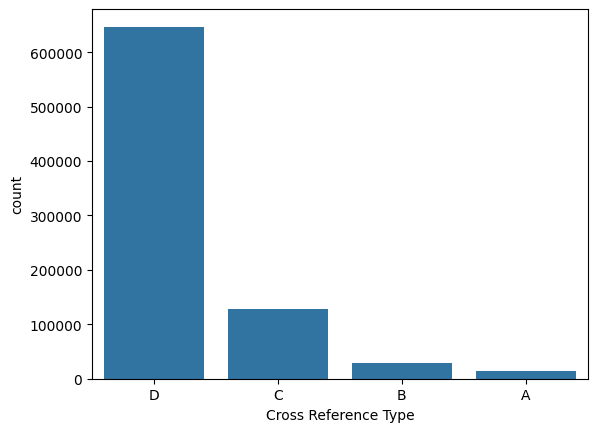

In [46]:
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

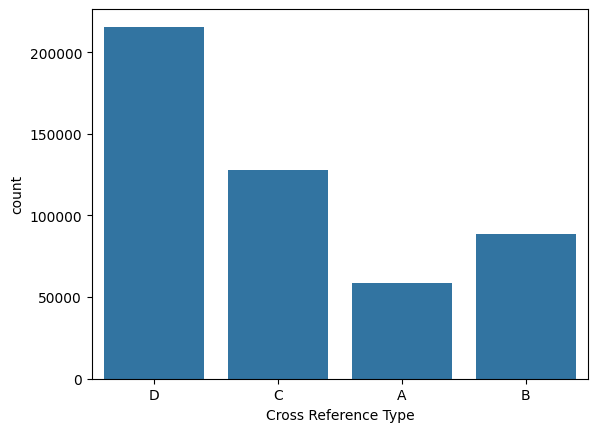

In [47]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
sns.countplot(df_train, x="Cross Reference Type")
plt.show()

# Splitting Data

In [48]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp", 'Mean', 'Std', "Cross Reference Type"]

In [49]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'distance_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance', 'Closeness'],
      dtype='object')

In [50]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp",'distance_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance' , "Cross Reference Type"]

In [51]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [52]:
categorical_columns+=[i +"_comp" for i in categorical_columns]

In [53]:
categorical_columns

['Supplier_Package', 'Supplier_Package_comp']

In [54]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'distance_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance', 'Closeness'],
      dtype='object')

# ML models

In [55]:
results = {}

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),

    ],
    remainder='passthrough'
)

## Decision Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])

<Axes: xlabel='Predicted Closeness', ylabel='Density'>

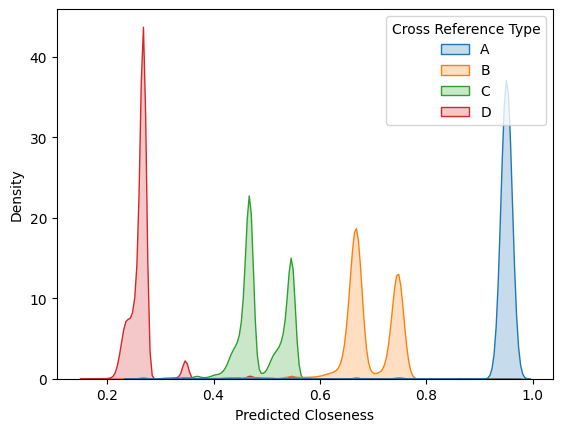

In [60]:
pipeline.fit(X_train, y_train)
#3min 8s
# Predict and store results
y_pred = pipeline.predict(X_test)
results["Decision Tree"] = mean_squared_error(y_test, y_pred)
df_test["Predicted Closeness"] = y_pred
sns.kdeplot(data=df_test.sort_values("Cross Reference Type"), x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False)

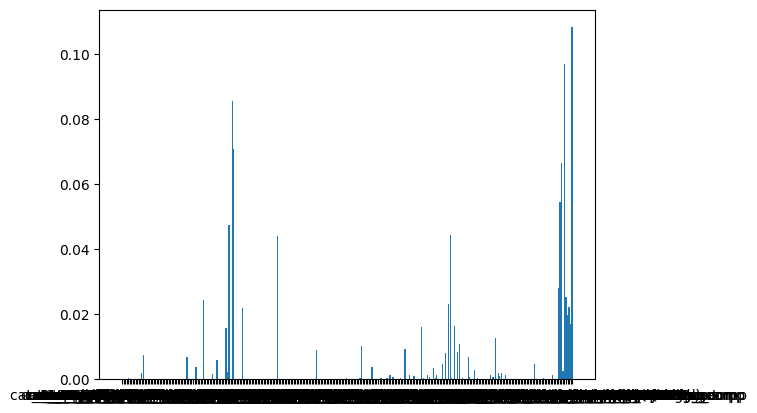

In [61]:
tree_model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']
feature_importance = tree_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
plt.bar(feature_names, feature_importance)
plt.show()

In [62]:
from sklearn.tree import export_text
tree_model = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]  # Fallback if not supported

tree_rules = export_text(tree_model, feature_names=feature_names)

In [63]:
print(tree_rules)

|--- cat__Supplier_Package_SOIC N <= 0.50
|   |--- remainder__Typical Gain Bandwidth Product <= 0.01
|   |   |--- remainder__Typical Gain Bandwidth Product_comp <= 0.01
|   |   |   |--- cat__Supplier_Package_PDIP <= 0.50
|   |   |   |   |--- cat__Supplier_Package_comp_SOIC <= 0.50
|   |   |   |   |   |--- cat__Supplier_Package_comp_PDIP <= 0.50
|   |   |   |   |   |   |--- cat__Supplier_Package_SO N <= 0.50
|   |   |   |   |   |   |   |--- cat__Supplier_Package_comp_SOIC N <= 0.50
|   |   |   |   |   |   |   |   |--- cat__Supplier_Package_SOIC <= 0.50
|   |   |   |   |   |   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.23
|   |   |   |   |   |   |   |   |   |   |--- remainder__Minimum Single Supply Voltage <= 0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 68
|   |   |   |   |   |   |   |   |   |   |--- remainder__Minimum Single Supply Voltage >  0.06
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 53
|   |   

In [64]:
import helper_functions.test as tt
importlib.reload(tt)
tt.create_closeness_matrix(df_feat_scaled,pipeline, output_path="closeness_matrix Decision Tree sans manufacturer.npy")

Building closeness matrix:   0%|          | 0/18352 [00:00<?, ?it/s]

Building closeness matrix: 100%|██████████| 18352/18352 [09:07<00:00, 33.51it/s]


'closeness_matrix Decision Tree sans manufacturer.npy'

In [ ]:
data = np.load("closeness_matrix Decision Tree sans manufacturer.npy", mmap_mode='r')

In [ ]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix(data , "matrix Decision tree.png")